<a href="https://colab.research.google.com/github/egustavo20/dataset_datascience/blob/master/An%C3%A1lise_de_dados_Amigo_edu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amigo Edu - BI Challenge

<center><img alt="Analisando Airbnb" width="39%" src="https://amigoedu.com.br/cafa741738ba8e40e117962851183a99.png"></center>


No contexto de vendas e marketing online, muitas vezes os usuários são direcionados ao site por diferentes canais (ads em redes sociais, email marketing, Google, etc). Também é comum que os usuários visitem diversas vezes o site antes de realizar uma compra. Nesse desafio você deve analisar os registros de conversões (vendas) de um e-commerce hipotético.


## Importando dados

In [ ]:
#importando bibliotecas
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#Importando arquivo SQL
con = sqlite3.connect('/content/amigoedu_bi_challenge.db')
cursor = con.cursor()

In [ ]:
#Identificando tabelas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('table_A',), ('table_B',)]


## Dicionário das variáveis

* `convId` - ID da transação
* `userId` - ID do cliente
* `revenue` - Valor da transação
* `createdAt` - Data da trasação
* `channel` - canal de marketing
* `ihcFrac` - contribuição do canal para a conversão



## Tratamento dos dados

In [ ]:
#Importando 'table_B'
df = pd.read_sql_query("select * from table_B;", con)
display(df.head())

print("\n\n Dimensões da table_B:",df.shape)

,convId,channel,ihcFrac
0,881152bb20f9b73daafb99d77714f38ac702629c,H,1.000000
1,faf5c1181ea84a32237dff45ca201d2c28f19d7b,I,0.300250
2,faf5c1181ea84a32237dff45ca201d2c28f19d7b,A,0.322839
3,faf5c1181ea84a32237dff45ca201d2c28f19d7b,E,0.376911
4,b0e58a88459ece1b585ca22c93e633dc56273b83,H,1.000000




 Dimensões da table_B: (211060, 3)


In [ ]:
#Importando 'table_A'
df1 = pd.read_sql_query("select * from table_A;", con)
display(df1.head())

print("\n\n Dimensões da table_A:",df1.shape)

,convId,userId,revenue,createdAt
0,881152bb20f9b73daafb99d77714f38ac702629c,5094298f068196c5349d43847de5afc9125cf989,47.00000,06-03-2017
1,faf5c1181ea84a32237dff45ca201d2c28f19d7b,None,98.00004,02-03-2017
2,b0e58a88459ece1b585ca22c93e633dc56273b83,None,180.35300,02-03-2017
3,f0e6b7de22332c7b18c024e550bb1d860130cdf1,433fdf385e33176cf9b0d67ecf383aa928fa261c,201.94104,23-03-2017
4,966568c7c859480c79b212520d20a51e735fd735,None,197.47008,03-03-2017




 Dimensões da table_A: (79643, 4)


In [ ]:
#Montando Dataframe (Base_final = 'table_B' + 'table_A') 

df_bd = pd.merge(df1,df,how='right',on='convId')
df_bd.head()

,convId,userId,revenue,createdAt,channel,ihcFrac
0,881152bb20f9b73daafb99d77714f38ac702629c,5094298f068196c5349d43847de5afc9125cf989,47.00000,06-03-2017,H,1.000000
1,faf5c1181ea84a32237dff45ca201d2c28f19d7b,None,98.00004,02-03-2017,I,0.300250
2,faf5c1181ea84a32237dff45ca201d2c28f19d7b,None,98.00004,02-03-2017,A,0.322839
3,faf5c1181ea84a32237dff45ca201d2c28f19d7b,None,98.00004,02-03-2017,E,0.376911
4,b0e58a88459ece1b585ca22c93e633dc56273b83,None,180.35300,02-03-2017,H,1.000000


In [ ]:
 # Conversão da coluna 'createdAt' para datetime 
df_bd['createdAt'] = pd.to_datetime(df_bd.createdAt,format="%d-%m-%Y")

# Criando novas features de tempo

df_bd['day'] = df_bd.createdAt.dt.day
df_bd['week'] = df_bd.createdAt.dt.weekday
df_bd['month'] = df_bd.createdAt.dt.month
df_bd['year'] = df_bd.createdAt.dt.year

In [ ]:
# Encurtando ID para 10 caracteres para otimizar vizualizações e busca
df_bd['convId'] = df_bd['convId'].str.slice(0,10)
df_bd['userId'] = df_bd['userId'].str.slice(0,10)
df_bd.set_index('convId',inplace=True)

## Pré análise estrutural dos dados

In [ ]:
#Tipo das variáveis e dimenmsões do dataframe
print("Variáveis: \t {}".format(df_bd.shape[1]))
print("Entradas: \t {}\n".format(df_bd.shape[0]))

display(df_bd.dtypes)

Variáveis: 	 9
Entradas: 	 211060



userId               object
revenue             float64
createdAt    datetime64[ns]
channel              object
ihcFrac             float64
day                   int64
week                  int64
month                 int64
year                  int64
dtype: object

In [ ]:
#Identificando valores nulos
print(df_bd.isnull().sum()/df_bd.shape[0]*100,"\n")


print("Entradas vazias de 'userId' :",df_bd['userId'].isnull().sum())
print("Entradas de 'userId' :",df_bd['userId'].value_counts().sum(),"\n")
print("# Quantidade total de 'userId' ou clientes :",df_bd.shape[0])

userId       3.145077
revenue      0.000000
createdAt    0.000000
channel      0.000000
ihcFrac      0.000000
day          0.000000
week         0.000000
month        0.000000
year         0.000000
dtype: float64 

Entradas vazias de 'userId' : 6638
Entradas de 'userId' : 204422 

# Quantidade total de 'userId' ou clientes : 211060


Observando a presença de valores nulos, temos uma pequena concentração na variável `userId ` com 3,15% de dados ausentes. Cosiderando essa uma proporção bem pequena, não teremos problemas inicialmente no contexto de analise, pois o insight que iremos tirar dela é quantitativo. Mais cabe essa nota de atenção, para acompanharmos se no decorrer do tempo com novos inputs de abastecimento desses dados, esse valor de ausentes está crescendo.

## Informações Estatística aderência de conversão e transações

In [ ]:
#Analise estatistica das variaveis
df_bd[['ihcFrac','revenue']].describe()

,ihcFrac,revenue
count,211060.000000,211060.000000
mean,0.377215,182.981662
std,0.359694,112.530454
min,0.000000,20.000000
25%,0.021454,116.132000
50%,0.301501,161.352000
75%,0.578395,217.744000
max,1.000000,4596.476000


Nessa análise estatística, podemos observar de forma macro a distribuição entre as variáveis tornando explícito os pontos onde podemos extrair bons insights:

*  Observando a variável `ihcFrac` podemos dizer que a maior concentração dos dados proporcionalmente em 75% tem como resultado 0.58. E comparando a conversão em efetivo por meio do canal que equivale a 1.0 podemos dizer, que temos uma aderência da maior parte dos acessos em 58% de contribuição do canal para conversão.

* Para a variável `revenue` conseguimos ver que 75% das transações realizadas tem como receita 217,74 podendo chegar no minimo em 20,00. Iremos ivestigar esse valor máx pois olhado para o desvio padrão, possivelmente existe a presença de outliers.


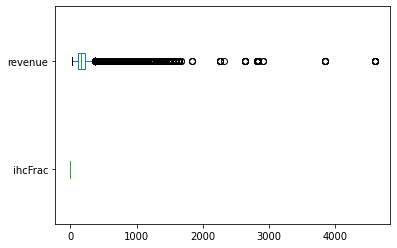


 Quantidade entradas acima de 2000 -> 40
% entradas acima de 2000 -> 0.01895195678953852


In [ ]:
df_bd[['ihcFrac','revenue']].plot(kind='box', vert=False)
plt.show()

print("\n Quantidade entradas acima de 2000 ->",len(df_bd.loc[df_bd.revenue>2000]))
print("% entradas acima de 2000 ->",len(df_bd.loc[df_bd.revenue>2000])/df_bd.shape[0]*100)

Como podemos observar na analise de `box-plot` possivelmente intervalos acima de 2000 esteja realmente fora de serie, para que possamos trabalhar com um cenário melhor reflete a realidade, estaremos copiando um dataset sem esse intervalo.

In [ ]:
#Remoçaõ de outliers
df_clean = df_bd.copy()
df_clean.drop(df_clean[df_clean.revenue>2000].index, axis=0, inplace= True)

## Volume de receita e índice de IhcFrac 


In [ ]:
print("# Variação de volume de receitas `revenue`:\n\t")
display(df_clean.groupby('year')['revenue'].agg(["sum","mean","median","max","min","count"]).astype(int))

# Variação de volume de receitas `revenue`:
	


,sum,mean,median,max,min,count
year,,,,,,
2017,29256106,183,161,1832,20,159120
2018,9238222,178,160,1500,27,51900


In [ ]:
print("# Variação de conversão índice de `ihcFrac` :\n\t")
display(df_clean.groupby('year')['ihcFrac'].agg(["mean","median","max","min","count"]))

# Variação de conversão índice de `ihcFrac` :
	


,mean,median,max,min,count
year,,,,,
2017,0.388286,0.310904,1.0,0.0,159120
2018,0.343410,0.281870,1.0,0.0,51900


Na analise das duas variáveis devemos deixar claro que a quantidade de inputs para os meses são bem descrepantes, devido ao fato do nosso dataset ter apenas 3 meses de registro para o ano de 2018 e para o ano de 2017 temos 10 meses. Estamos falando de uma proporção de 75% para 25% ou seja, não devemos comparar os anos mais podemos olhar para o ano de 2017 utilizando seus valores como regua de valores que já alcançamos, utilizando esses resultados como oportunidade de alavancagem no caso de benchmarks e alarme em aproximações de piores resultados já alcançado.  

# Analise temporal de média de receita e índice de IhcFrac

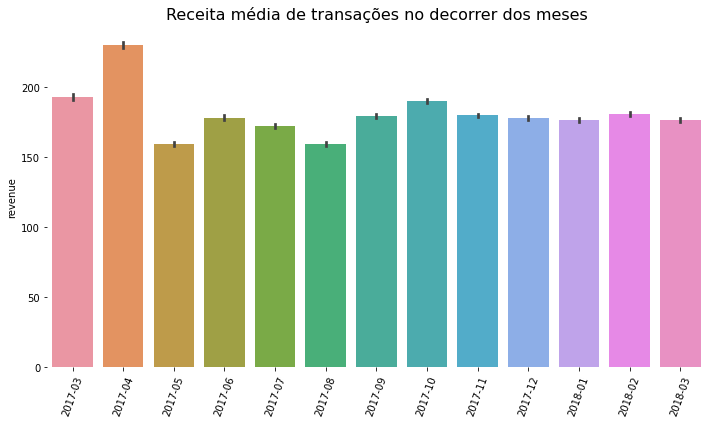



2017-03    192.915948
2017-04    230.309266
2017-05    159.145032
2017-06    178.105803
2017-07    172.060884
2017-08    159.100173
2017-09    178.945587
2017-10    190.230226
2017-11    179.822636
2017-12    177.743031
2018-01    176.346451
2018-02    180.794420
2018-03    176.648412
Name: revenue, dtype: float64


In [ ]:
#Variação de média mês

month_year = pd.to_datetime(df_clean.createdAt).dt.strftime('%Y-%m')
month_or = sorted(month_year)

rece = df_clean['revenue']

fig, ax= plt.subplots(figsize=(10,6))

sns.barplot(x=month_or, y=rece,ax=ax)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlabel("")

plt.title("Receita média de transações no decorrer dos meses", fontsize=16)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

print("\n")
print(df_clean.groupby(month_or,sort=False)['revenue'].mean())

  Quando plotamos os resultados médio de custo de transações em função dos meses, podemos concluir que o mês de Abr/17 foi onde tivemos a melhor variação de receita com 230,31. E se compararmos 3 meses de cada ano e conflitar as médias, teremos ainda melhor desempenho para o ano de 2017 em relação a 2018.

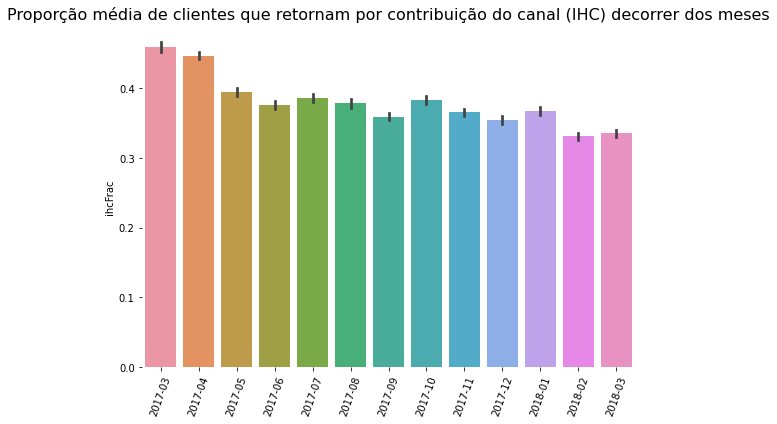



2017-03    0.459101
2017-04    0.445891
2017-05    0.394192
2017-06    0.376254
2017-07    0.385779
2017-08    0.377824
2017-09    0.358518
2017-10    0.382847
2017-11    0.364957
2017-12    0.354009
2018-01    0.366423
2018-02    0.330717
2018-03    0.334753
Name: ihcFrac, dtype: float64 




In [ ]:
#Variação de média mês

ihcFrac = df_clean['ihcFrac']

fig, ax= plt.subplots(figsize=(10,6))

sns.barplot(x=month_or, y=ihcFrac,ax=ax)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xlabel("")

plt.title("Proporção média de clientes que retornam por contribuição do canal (IHC) decorrer dos meses", fontsize=16)
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

print("\n")
print(df_clean.groupby(month_or,sort=False)['ihcFrac'].mean(),"\n\n")

Avaliando a proporção de contribuição dos canais, tivemos as melhores médias entre os meses de Mar/17 (0.46-46%) e Abr/17 (0.44-44%) ambos tiveram, também os melhores valores médio em retorno de transação. O ponto de atenção fica para o ano de 2018 que vem apresentando, uma tendência de queda na contribuição de conversão entre os canais. Para compreender o comportamento desses canais no ano de 2018 com intuito, de identificarmos  oportunidade entre os canais de baixo engajamento e alto egajamento, iremos estratificar a distribuição por canal.

## Estratificando a representatividade de canais do ano 2018 e abrindo a receita e índice de IhcFrac

In [ ]:
#Proporção de canais por quantidade de trasações realizada 2018
df_18 = df_clean.loc[df_clean.year==2018]
print(" # top 10 canais com mais transações:\n")
print(((df_18.channel.value_counts()/df_18.shape[0]*100)[:10]),"\n\n")

print(" # top 10 canais com menos transações:\n")
print((df_18.channel.value_counts()/df_18.shape[0]*100).sort_values(ascending=True)[0:10])

 # top 10 canais com mais transações:

G    16.809249
A    15.861272
H    12.890173
B    12.558767
E    11.296724
I     8.269750
C     4.186898
K     4.152216
F     3.082852
S     2.861272
Name: channel, dtype: float64 


 # top 10 canais com menos transações:

N    0.030829
J    0.057803
V    0.084778
T    0.084778
O    0.113680
P    0.269750
U    0.271676
M    1.215800
D    1.585742
R    1.587669
Name: channel, dtype: float64


A concentração de 80% das transações dos canais com maior representatividade, esta no intervalo do canal G até I esses são os pricipais canais utilizados pelos clientes, que possuem maior representatividade em 2018. Agora vamos aplicar a estratificação nos KPI's (Receita e índice de IhcFrac) para avaliar o desempenho desses top 10 canais com mais transações.

In [ ]:
# Top 10 canais com mais transações 2018 `revenue`
print("# Variação de volume de receitas `revenue` por canal :\n\t")
df_18.groupby('channel')['revenue'].agg(["mean","median","max","min","count"]).sort_values(by='count',ascending=False)[:10]

# Variação de volume de receitas `revenue` por canal :
	


,mean,median,max,min,count
channel,,,,,
G,178.775338,159.758,1500.232,28.532,8724
A,184.101651,166.224,1500.232,36.532,8232
H,174.292794,155.536,1257.360,27.532,6690
B,181.156857,165.724,1257.360,27.532,6518
E,182.891668,166.092,1500.232,36.876,5863
I,175.560434,158.832,846.056,28.532,4292
C,183.767637,166.900,1232.696,34.532,2173
K,157.386710,136.504,957.064,31.532,2155
F,177.478737,166.606,1500.232,39.980,1600


In [ ]:
# Top 10 canais com mais transações 2018 `ihcFrac`
print("# Variação de conversão índice de `ihcFrac` por canal :\n\t")
df_18.groupby('channel')['ihcFrac'].agg(["mean","median","max","min","count"]).sort_values(by='count',ascending=False)[:10]

,mean,median,max,min,count
channel,,,,,
G,0.459167,0.399088,1.0,0.0,8724
A,0.461445,0.427892,1.0,0.0,8232
H,0.362007,0.300007,1.0,0.0,6690
B,0.400576,0.317908,1.0,0.0,6518
E,0.229525,0.113331,1.0,0.0,5863
I,0.253351,0.114904,1.0,0.0,4292
C,0.243035,0.300067,1.0,0.0,2173
K,0.268293,0.105186,1.0,0.0,2155
F,0.143461,0.020980,1.0,0.0,1600


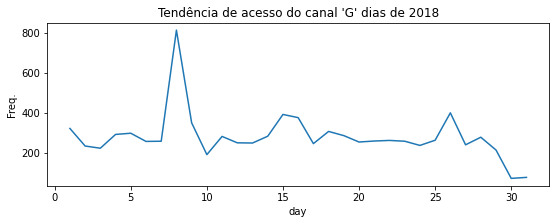

In [ ]:
#Distribuição de frequência em dias para o canal mais acessado em 2018 "G"
G = df_18[df_18.channel=='G']

G['day'].value_counts().sort_index(ascending=True).plot(figsize=(9,3))

plt.xlabel("day")
plt.ylabel("Freq.")
plt.title("Tendência de acesso do canal 'G' dias de 2018")

plt.show()


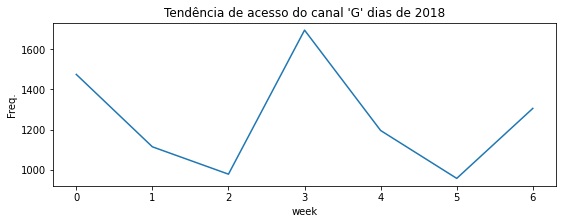

In [ ]:
#Distribuição de frequência em dias para o canal mais acessado em 2018 "G"
G = df_18[df_18.channel=='G']

G['week'].value_counts().sort_index(ascending=True).plot(figsize=(9,3))

plt.xlabel("week")
plt.ylabel("Freq.")
plt.title("Tendência de acesso do canal 'G' dias de 2018")

plt.show()

Observando os graficos acima, podemos extrair alguns 
insight, com sua distrubuição de freqência de acessos no decorrer do tempo:

*  Existe uma pico de acessos concentrado entre os **dias 7 e 9** tendendo a uma queda no dia 10 seguindo uma estabilidade dos acessos até o fim do mês.

*  Quando olhamos no gráfico de semanas confirmamos, que a segunda semana dos meses de 2018 para o canal *G* tendem a ser bons.




Caso seja necessário uma pesquisa especifica por `userId' ou cliente` o código de cliente basta digitar os 10 primeiros digitos no campo **search** abaixo entre aspas:

In [ ]:
#Campo de procura por ID de cliente

search ='881152bb20'

df_clean.loc[search]

userId                5094298f06
revenue                       47
createdAt    2017-03-06 00:00:00
channel                        H
ihcFrac                        1
day                            6
week                           0
month                          3
year                        2017
Name: 881152bb20, dtype: object

In [ ]:
#Gerar carga 'csv' do arquivo para trabalhar em plataformas de Self-Service BI

df_clean.to_csv('Bd_amigo_edu.csv')